## Importations de package

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image,ImageDraw
import skimage.morphology as morpho
from skimage.segmentation import watershed,mark_boundaries
import scipy.spatial as sp
import scipy.ndimage as nd

## Gradient morphologique

Text(0.5, 1.0, 'Gradient morphologique')

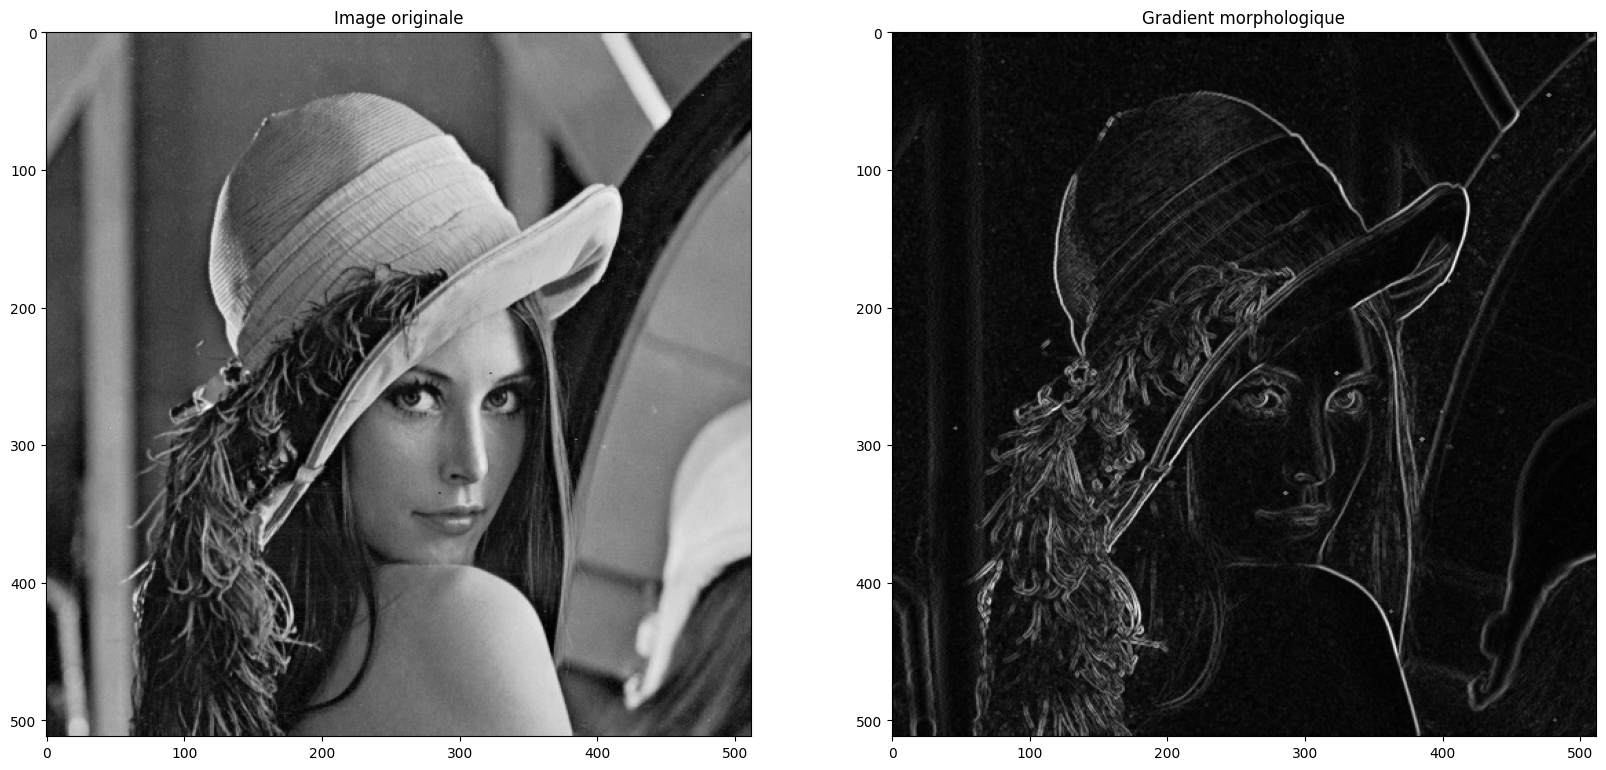

In [11]:
img = io.imread('images/lena.tif')



def gradmorpho(img):

    se = morpho.disk(1)
    morpho_grad = morpho.dilation(img,se) - morpho.erosion(img, se)

    return morpho_grad

grad_morpho = gradmorpho(img)

fig,ax = plt.subplots(1,2,figsize = (20,15))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(grad_morpho,cmap = "gray")
ax[1].set_title('Gradient morphologique')


## Cellules hexagonales

In [12]:
def calcul_hexa_centers(img,taille):
    colonnes, lignes = img.size
    hexa_centers = []
    p_horizontal=3*taille*0.5
    p_vertical=np.sqrt(3)*taille
    I = int(colonnes/p_horizontal) + 2 #I est le nombre de centres par ligne
    J = int(lignes/p_vertical) + 2 #J est le nombre de centres par colonne
    for i in range(I):
        for j in range(J):
            if i%2==0:
                hexa_centers.append((int(i*p_horizontal) ,int(j*p_vertical)))
            else:
                hexa_centers.append((int(i*p_horizontal),int((j*p_vertical)+p_vertical/2)))
    return hexa_centers

"""
hexa_centers = calcul_hexa_centers(img,10)
lignes, colonnes = img.shape
img_test = np.zeros((lignes,colonnes))+255
for center in hexa_centers:
    #if center[0]<lignes and center[1]<colonnes:
    img_test[center[0]][center[1]] = 0
plt.imshow(img_test,cmap='gray')
print(hexa_centers)
#hexa_contours = np.zeros((lignes,colonnes,1))
"""


"\nhexa_centers = calcul_hexa_centers(img,10)\nlignes, colonnes = img.shape\nimg_test = np.zeros((lignes,colonnes))+255\nfor center in hexa_centers:\n    #if center[0]<lignes and center[1]<colonnes:\n    img_test[center[0]][center[1]] = 0\nplt.imshow(img_test,cmap='gray')\nprint(hexa_centers)\n#hexa_contours = np.zeros((lignes,colonnes,1))\n"

In [13]:
def hexa_sommets(centre, t, rho):
    x,y = centre
    taille= t*rho
    return [(x+taille,y),
            (x+(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-taille,y),
            (x-(taille/2),y-(taille*np.sqrt(3)/2)),
            (x+(taille/2),y-(taille*np.sqrt(3)/2))
            ]


Text(0.5, 1.0, 'rho=0.9')

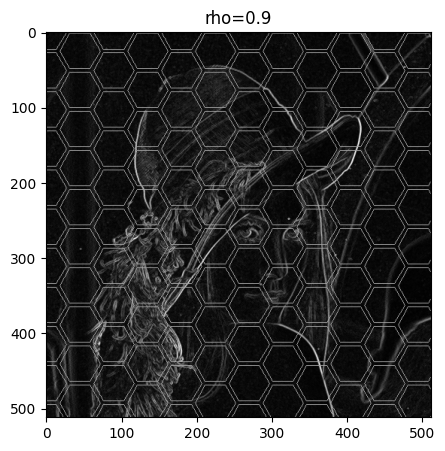

In [14]:
def hexagon_grid(img, taille, rho):
    img_grid = img.copy()
    draw = ImageDraw.Draw(img_grid)
    hexa_centers = calcul_hexa_centers(img,taille)

    for c in hexa_centers:
        p = hexa_sommets(c, taille, rho)
        draw.polygon((p),outline="gray")

    return img_grid

im = Image.fromarray(np.uint8(grad_morpho))
hexa = hexagon_grid(im,30,0.9)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(hexa, cmap='gray')
ax.set_title('rho=0.9')


## Sélection des marqueurs

In [15]:
def point_dans_hexagon(centre,point,taille):
    x,y = point[0]-centre[0],point[1]-centre[1]
    distance = math.sqrt((x**2)+(y**2))
    if distance > 0:
        theta = math.acos(x/distance)
        theta = theta%(np.pi/3)
        distance_max=0
        if(theta<=np.pi/6):
            distance_max = taille*((((math.sqrt(3)*0.5)-1)*6*theta/np.pi)+1)
        else:
            distance_max = taille*(6*theta*(1-(math.sqrt(3)*0.5))/np.pi)+math.sqrt(3)-1
        return distance < distance_max
    else:
        return True

In [16]:
def extract_hex_points(centre,taille):
    square = []
    hex=[]
    for x in range(-taille,taille):
        for y in range(-taille,taille):
            square.append((centre[0]+x,centre[1]+y))
    for s in square:
        if(point_dans_hexagon(centre,s,taille)):
            hex.append(s)
    return hex

Text(0.5, 1.0, 'Minima du gradient en blanc')

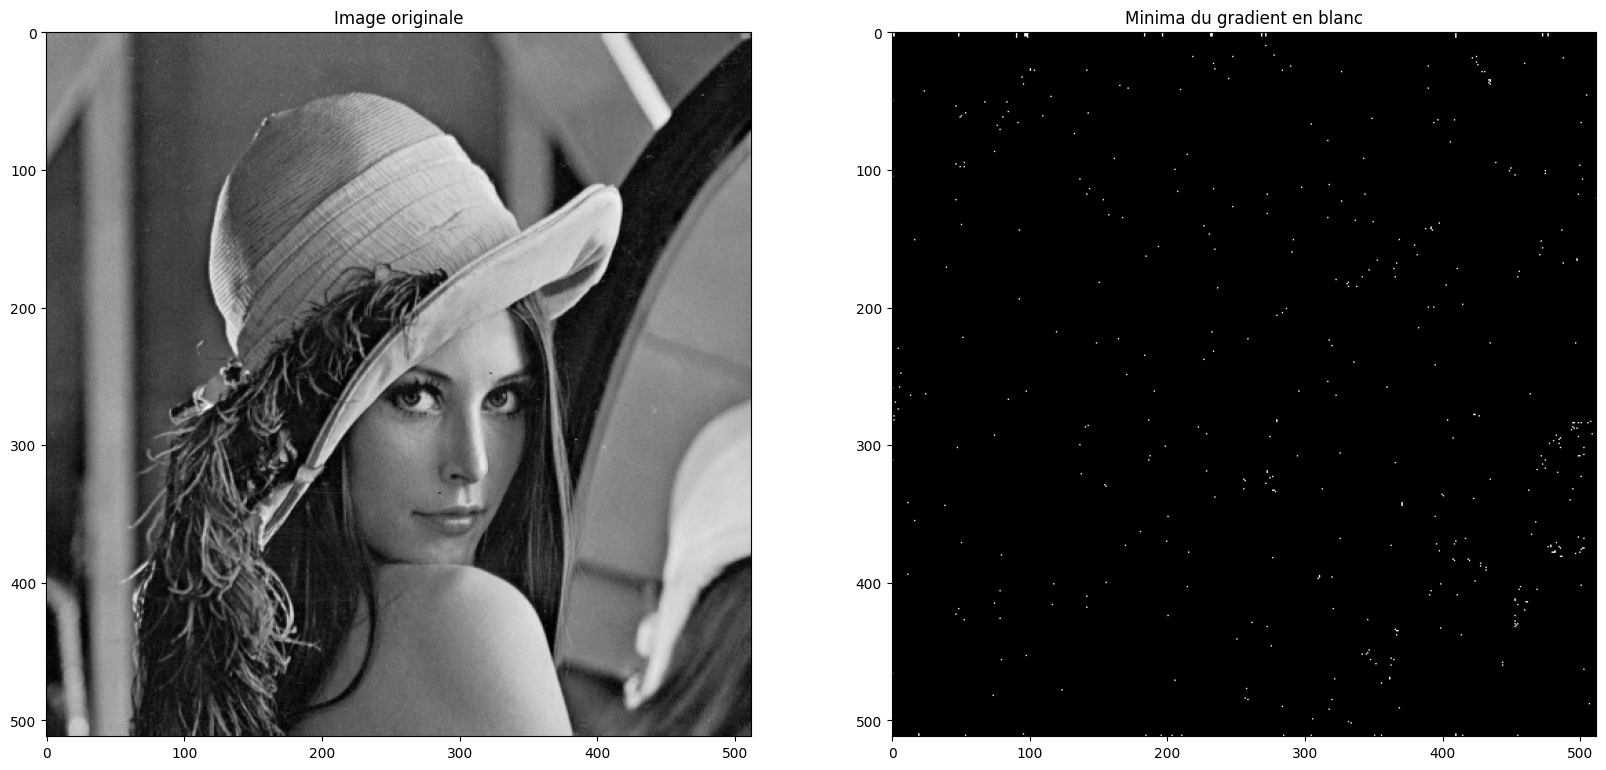

In [17]:
def extract_hex_grad_min(grad_im,c,taille):
    hex_points = extract_hex_points(c,taille)
    grad_hex = []
    grad_coord = []
    lignes, colonnes = grad_im.size
    for p in hex_points:
        if (p[0]>=0 and p[0]<lignes and p[1]>=0 and p[1]<colonnes):
            grad_hex.append(grad_im.getpixel((p[0],p[1])))
            grad_coord.append((p[0],p[1]))
    grad_hex = np.array(grad_hex)
    if len(grad_hex)>0:
        min_indices = np.where(grad_hex == grad_hex.min())[0]
        min_grad = grad_hex[min_indices[0]]
        min_coord = [grad_coord[i] for i in min_indices]
        return min_grad, min_coord
    else:
        return 0, [c]

s=[]
for c in calcul_hexa_centers(im,30):
    s.append(extract_hex_grad_min(im,c,int(30*0.9)))

colonnes, lignes = im.size

img_selection_marqueur = Image.new(mode='L',size=im.size,color=0)

for hexagon in s:
    min_grads = hexagon[0]
    min_coords = hexagon[1]
    for i in range(len(min_coords)):
        xy = min_coords[i]
        if xy[0]<lignes and xy[0]>=0 and xy[1]<colonnes and xy[1]>=0:
            img_selection_marqueur.putpixel(xy,255)
fig,ax = plt.subplots(1,2,figsize = (20,15))
#hexa.show()
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(img_selection_marqueur,cmap = "gray")
ax[1].set_title('Minima du gradient en blanc')

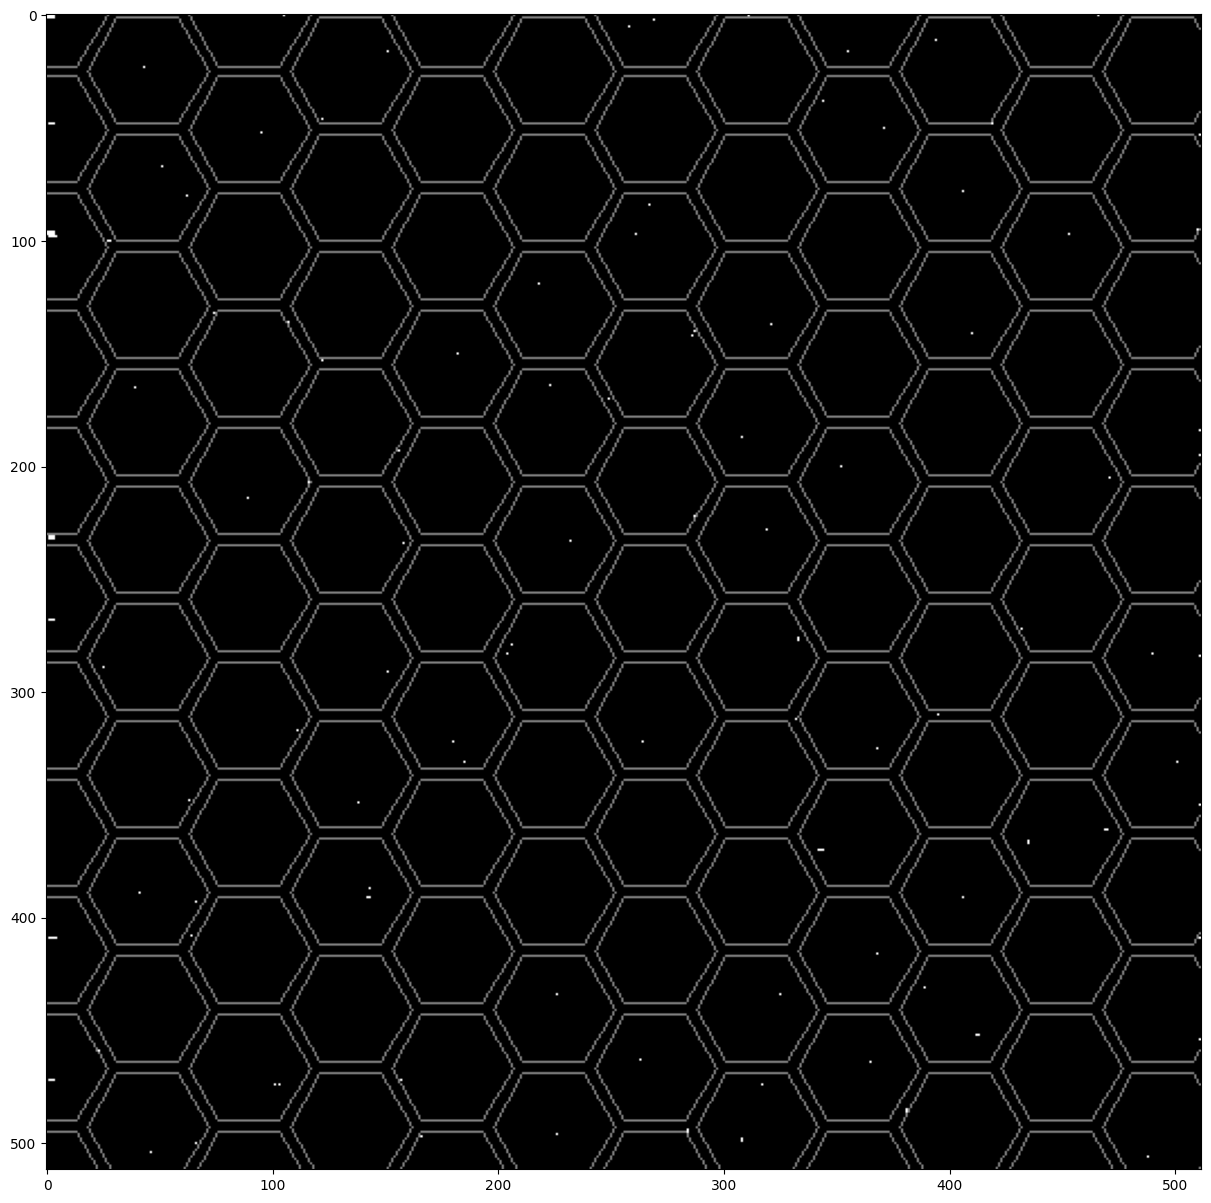

In [18]:
def selection_marqueurs(grad_min_im,taille):
    marqueurs = []
    img_seuille = np.where(np.array(grad_min_im)>254,255,0)
    img_labelise = nd.label(img_seuille)[0]
    colonnes, lignes = img_seuille.shape
    centres = calcul_hexa_centers(grad_min_im,taille)
    for c in centres:
        h={}
        hex = extract_hex_points(c,taille)
        valeurs=[]
        for p in hex:
            x = p[0]
            y = p[1]
            if x<colonnes and x>=0 and y<lignes and y>=0:
                value = img_labelise[x][y]
                valeurs.append(value)
                if value != 0:
                    if value in h:
                        h[value] += 1
                    else:
                        h[value] = 1
        val_max = 1
        if(len(h)>0):
            val_max = max(h,key = h.get)
        comp_connex_max = []
        for p in hex:
            x = p[0]
            y = p[1]
            if x<colonnes and x>=0 and y<lignes and y>=0:
                value = img_labelise[x][y]
                if value == val_max:
                    comp_connex_max.append((x,y))
        marqueurs.append(comp_connex_max)
    return marqueurs


s=selection_marqueurs(img_selection_marqueur,int(30*0.9))
"""
len_max = max([len(i) for i in s])
for i in s:
    if len(i)==len_max:
        print(i)
"""
new_temp_img = Image.new(mode="L",size=img_selection_marqueur.size,color=0)
colonnes,lignes = im.size
for grad_coord in s:
    for i in range(len(grad_coord)):
        xy = grad_coord[i]
        if xy[0]<lignes and xy[0]>=0 and xy[1]<colonnes and xy[1]>=0:
            new_temp_img.putpixel(xy,255)
#new_temp_img.show()


temp_hexa = hexagon_grid(Image.fromarray(np.uint8(new_temp_img)),30,0.9)
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(temp_hexa, cmap='gray')